[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/repos-especializacion-UdeA/trabajo-final_AA1/blob/main/notebooks_pasos_previos/07_evaluacion_entre_modelos_clasificacion.ipynb)

# Evaluación entre diferentes Modelos de Clasificación

## Autores

* Jairo Agudelo M.
* Henry Arcila.

## Descripción corta del dataset

El dataset a trabajar [db1_rms_prue.csv](./datasets_tarea/db1_rms_prue.csv) es uno de los dataset resultantes de la etapa previa de preparacion del dataset ([link](01_preparacion_dataset_clasificacion.ipynb)). Cada entrada de la base de datos contiene los valores RMS de cada uno de los 10 sensores EMG para una ventana de tiempo de 30 muestras de señal y la postura a la cual se asocia esta venta. A continuación se describen cada una de las columnas de la muestra.

Esta base de datos se describe a continuación:

| Columna               | Descripción                                       | Ejemplo   |
|:----------------------|:--------------------------------------------------|:----------|
| `emg1`                | Valor RMS sensor 1                                | 0.052510  | 
| `emg2`                | Valor RMS sensor 2                                | 0.002414  |	
| `emg3`                | Valor RMS sensor 3                                | 0.002445  |
| `emg4`                | Valor RMS sensor 4                                | 0.002417  |
| `emg5`                | Valor RMS sensor 5                                | 0.002400  |
| `emg6`                | Valor RMS sensor 6                                | 0.006204  |
| `emg7`                | Valor RMS sensor 7                                | 0.0024    |
| `emg8`                | Valor RMS sensor 8                                | 0.041218  |
| `emg9`                | Valor RMS sensor 9                                | 0.0024    |
| `emg1p`               | Valor RMS sensor 10                               | 0.019526  |
| `label`               | Numero de la postura realizada  (1 - 12)          | 5         |

Este dataset se empleara para evaluar el desempeño de los diferentes modelos de clasificación creados.


## Objetivo a desarrollar

> Comparar los modelos entrenados mediante el uso de datos de prueba.

## Resumen del proceso realizado

Empleando los datos de prueba, se cargaron los modelos y se realizaron las pruebas para ver que tan bien funcionaban.

## Desarrollo de experimentos

## 1. Librerias y configuraciones previas


In [1]:
# Determinacion si el archivo se va a ejecutar desde colab o local y configuracion de los elementos necesarios para la ejecucion
import sys
import os

# Path del notebook
notebook_path = "."
print(notebook_path)
try:
    import google.colab
    !git clone https://github.com/repos-especializacion-UdeA/trabajo-final_AA1.git
    %cd /content/trabajo-final_AA1/notebooks_pasos_previos   
    %pwd
    ruta_base = '/content/trabajo-final_AA1/notebooks_pasos_previos/'
    sys.path.append(ruta_base)
except ImportError:
    print("El notebook no se está ejecutando en Google Colab.")
    ruta_base = './'

.
El notebook no se está ejecutando en Google Colab.


In [2]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np


# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib
import os


# Gestion de librerias
# ==============================================================================
from importlib import reload


# Matemáticas y estadísticas
# ==============================================================================
import math


# Preparación de datos
# ==============================================================================
from sklearn.neighbors import LocalOutlierFactor

#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split


#Escalar Variables
from sklearn.preprocessing import MinMaxScaler, label_binarize

#Evaluación del modelo
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


#Creación de modelo
from sklearn import svm


#configuracion de hiperparámetros
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## 2. Funciones

In [3]:
#reload(utils.funciones)

# Funciones externas
# ==============================================================================
from utils.funciones1 import multiple_plot, plot_roc_curve

## 3. Carga del dataset

In [4]:
#Carga del dataset

#Cargar el dataset
DATA_PATH = './datasets_tarea/'
dp = pd.read_csv( DATA_PATH + 'db1_rms_prue.csv')
dp.shape

(4693, 11)

In [5]:
dp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4693 entries, 0 to 4692
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   emg_1   4693 non-null   float64
 1   emg_2   4693 non-null   float64
 2   emg_3   4693 non-null   float64
 3   emg_4   4693 non-null   float64
 4   emg_5   4693 non-null   float64
 5   emg_6   4693 non-null   float64
 6   emg_7   4693 non-null   float64
 7   emg_8   4693 non-null   float64
 8   emg_9   4693 non-null   float64
 9   emg_10  4693 non-null   float64
 10  label   4693 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 403.4 KB


## 4. Visualización de datos

### Variables de entrada

In [6]:
#Lista de variables categóricas
catCols = dp.select_dtypes(include = ["object", 'category']).columns.tolist()

dp[catCols].head(2)

""
0
1


In [7]:
#Lista de variables numéricas

numCols=dp.select_dtypes(include = ['float64','float64','int32','int64']).columns.tolist()

dp[numCols].head(2)

,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9,emg_10,label
0,0.022518,0.002400,0.002476,0.002396,0.002533,0.002400,0.002539,0.026252,0.002398,0.002642,0
1,0.020472,0.002198,0.002775,0.002480,0.002522,0.002444,0.003877,0.024824,0.002369,0.002403,0


In [8]:
## Visualización de frecuencia de instancias para variables categóricas
#multiple_plot(3, dp , catCols, None, 'countplot', 'Frecuencia de instancias para variables categóricas',30)

In [9]:
## Visualización de variables numéricas
#multiple_plot(1, dp , numCols, None, 'scatterplot', 'Relación entre las variables numéricas',30)

In [10]:
#Eliminar la variable de salida de la lista de variable numéricas
numCols.remove('label')

### Variable de salida

In [11]:
# Distriución de la variable de salida

dp.groupby('label').label.count().sort_values(ascending=False)

label
0     2664
1      187
5      184
7      175
3      172
12     170
6      167
8      167
2      165
4      165
10     162
9      159
11     156
Name: label, dtype: int64

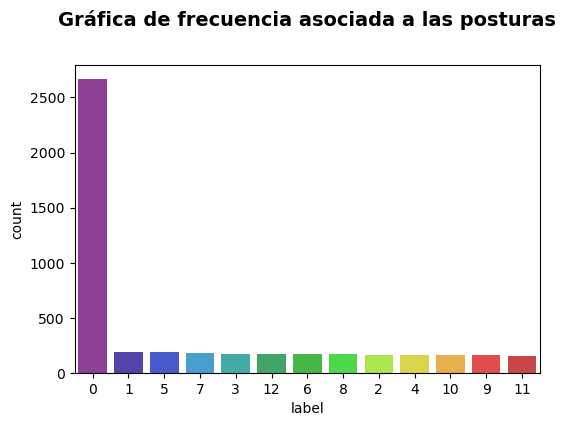

In [12]:
##Visualización de la variable de salida
multiple_plot(1, dp , None, 'label', 'countplot', 'Gráfica de frecuencia asociada a las posturas',0)

## 5. Transformación de datos

### Valores atípicos para las variables de entrada

In [13]:
#utilización de LocalOutlierFactor con 13 vecinos para identificar valores atípicos en las variables de entrada


# crear un objeto LocalOutlierFactor con n_neighbors=13
lof = LocalOutlierFactor(n_neighbors=26, contamination=0.1)

# identificar los valires atípicos por medio de lof 
y_pred = lof.fit_predict(dp[numCols])

# Identificar los índices de los valores atípicos
outliers = y_pred == -1

print('Indices de valores atípicos: ', dp[outliers].index.tolist())

Indices de valores atípicos:  [2, 5, 8, 9, 16, 39, 52, 54, 63, 71, 74, 85, 86, 99, 100, 101, 125, 134, 135, 137, 150, 152, 158, 212, 213, 215, 216, 217, 228, 239, 249, 250, 261, 269, 270, 295, 299, 305, 307, 308, 314, 315, 318, 319, 323, 342, 343, 345, 352, 353, 360, 362, 363, 375, 378, 382, 385, 386, 394, 395, 399, 423, 475, 487, 492, 543, 544, 545, 562, 565, 566, 574, 578, 588, 592, 597, 600, 603, 604, 613, 614, 615, 616, 618, 659, 660, 661, 675, 680, 710, 712, 713, 714, 716, 717, 721, 728, 729, 732, 735, 745, 746, 750, 752, 757, 758, 759, 760, 795, 843, 848, 849, 850, 907, 911, 935, 936, 937, 938, 939, 940, 941, 944, 946, 957, 958, 962, 971, 975, 979, 1008, 1009, 1010, 1018, 1023, 1026, 1034, 1037, 1043, 1044, 1046, 1048, 1053, 1055, 1063, 1100, 1101, 1109, 1113, 1114, 1120, 1129, 1140, 1162, 1163, 1167, 1174, 1176, 1218, 1331, 1332, 1342, 1350, 1356, 1359, 1400, 1425, 1433, 1435, 1436, 1438, 1452, 1456, 1486, 1489, 1496, 1497, 1498, 1505, 1537, 1544, 1545, 1550, 1574, 1581, 1582, 1

In [14]:
# Eliminar los valores atípicos del dataframe original
dp = dp.loc[~outliers]

### Creación de variables Dummies 

In [15]:
# Aplicación de la función de usuario Dummies: one-hot encoding

dp =pd.get_dummies(dp, drop_first=1)

dp.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4223 entries, 0 to 4692
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   emg_1   4223 non-null   float64
 1   emg_2   4223 non-null   float64
 2   emg_3   4223 non-null   float64
 3   emg_4   4223 non-null   float64
 4   emg_5   4223 non-null   float64
 5   emg_6   4223 non-null   float64
 6   emg_7   4223 non-null   float64
 7   emg_8   4223 non-null   float64
 8   emg_9   4223 non-null   float64
 9   emg_10  4223 non-null   float64
 10  label   4223 non-null   int64  
dtypes: float64(10), int64(1)
memory usage: 395.9 KB


### Columnas categóricas faltantes

In [16]:
#Carga del dataset

#Cargar el dataset
DATA_PATH = './datasets_tarea/'
d = pd.read_csv( DATA_PATH + 'db1_rms_prue.csv')
d.shape

(4693, 11)

In [17]:
# Aplicación de la función de usuario Dummies: one-hot encoding

d =pd.get_dummies(d, drop_first=1)

d.shape

(4693, 11)

In [18]:
# Obtener las columnas categóricas que están en el dataframe original pero no en el dataset de pruebas

missingCols = set(d.columns) - set(dp.columns)

# Agregar columnas con valores predeterminados 0
for col in missingCols:
    dp[col] = 0

In [19]:
dp

,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9,emg_10,label
0,0.022518,0.002400,0.002476,0.002396,0.002533,0.002400,0.002539,0.026252,0.002398,0.002642,0
1,0.020472,0.002198,0.002775,0.002480,0.002522,0.002444,0.003877,0.024824,0.002369,0.002403,0
3,0.012737,0.002320,0.002492,0.002448,0.002408,0.002399,0.007842,0.025439,0.002169,0.000621,0
4,0.019402,0.002400,0.002543,0.002463,0.002514,0.002400,0.005567,0.028935,0.002403,0.003020,0
6,0.057433,0.089231,0.012698,0.004522,0.003197,0.002639,0.097042,0.054926,0.106723,0.008969,1
...,...,...,...,...,...,...,...,...,...,...,...
4687,0.002685,0.006708,0.003443,0.002398,0.002509,0.002931,0.035649,0.117017,0.139825,0.027904,0
4688,0.002557,0.179093,0.226058,0.052751,0.018122,0.026103,0.203514,1.121665,1.058878,0.508435,12
4689,0.002731,0.015089,0.005418,0.002440,0.002598,0.002423,0.031736,0.112678,0.139218,0.022018,0
4691,0.002350,0.007746,0.003034,0.002401,0.002401,0.002385,0.017323,0.125097,0.125655,0.016718,0


In [20]:
#Se establece las variables de entrada 'X' y la variable de salida 'y'

Xp = dp.drop(columns ='label')
yp = dp['label']

In [21]:
#Escalar Variables númericas

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Cargar el scaler
scaler = joblib.load('./modelos/scaler/minmaxFull_label.pkl')

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
Xp[numCols] = scaler.transform(Xp[numCols])

Xp[numCols].head(2)

,emg_1,emg_2,emg_3,emg_4,emg_5,emg_6,emg_7,emg_8,emg_9,emg_10
0,0.0089,0.0007,0.0005,0.0006,0.0037,0.0011,0.0004,0.0058,0.0005,0.0009
1,0.0080,0.0006,0.0006,0.0006,0.0036,0.0011,0.0007,0.0055,0.0005,0.0008


## 6. Creación del modelo

#### Creación y entrenamiento del modelo

In [22]:
# Ruta donde se encuentran los modelos
ruta_modelos = './modelos/clasificacion'

In [23]:
# Lista para almacenar los modelos cargados
modelos_cargados = []
dr = pd.DataFrame()

# Itera sobre los archivos en la ruta
for archivo_modelo in os.listdir(ruta_modelos):
    # Comprueba si el archivo es un modelo (puedes ajustar esta comprobación según tu estructura de nombres)
    
    if archivo_modelo.endswith('.pkl'):
        ruta_completa = os.path.join(ruta_modelos, archivo_modelo)
    
        # Carga el modelo
        modelo_cargado = joblib.load(ruta_completa)

        # Agrega el modelo a la lista
        modelos_cargados.append(archivo_modelo)
         
        # Realizar predicciones (opcional)
        y_pred = modelo_cargado.predict(Xp)
        

        # Adicionar una nueva fila 
        nuevoModelo = {'model': archivo_modelo
                      , 'Descripcion': modelo_cargado
                      , 'accuracy': metrics.accuracy_score(yp, y_pred)
                      #, 'recall': metrics.recall_score(yp, y_pred)
                      #, 'f1_score': metrics.f1_score(yp, y_pred)
                      #, 'AUC': metrics.roc_auc_score(yp, y_pred)
                      , 'support': round(dp.shape[0],0)
                     }
        dr = dr.append(nuevoModelo, ignore_index=True)
        
    
# Imprimir el DataFrame actualizado
dr

,model,Descripcion,accuracy,support
0,AdaB_CV.pkl,"(DecisionTreeClassifier(max_depth=1, random_st...",0.3905,4223
1,DTreeC_CV.pkl,"DecisionTreeClassifier(criterion='entropy', ra...",0.6417,4223
2,KNN_CV_manhattan.pkl,"KNeighborsClassifier(metric='manhattan', n_nei...",0.7454,4223
3,LR_Ret_ovrLineal.pkl,"LogisticRegression(class_weight='balanced', mu...",0.5804,4223
4,RForest_CV.pkl,"(DecisionTreeClassifier(max_depth=20, max_feat...",0.7926,4223


In [24]:
# Top 3 de los mejores modelos
# dr.sort_values(by='f1_score', ascending=False)
dr.sort_values(by='accuracy', ascending=False)


,model,Descripcion,accuracy,support
4,RForest_CV.pkl,"(DecisionTreeClassifier(max_depth=20, max_feat...",0.7926,4223
2,KNN_CV_manhattan.pkl,"KNeighborsClassifier(metric='manhattan', n_nei...",0.7454,4223
1,DTreeC_CV.pkl,"DecisionTreeClassifier(criterion='entropy', ra...",0.6417,4223
3,LR_Ret_ovrLineal.pkl,"LogisticRegression(class_weight='balanced', mu...",0.5804,4223
0,AdaB_CV.pkl,"(DecisionTreeClassifier(max_depth=1, random_st...",0.3905,4223


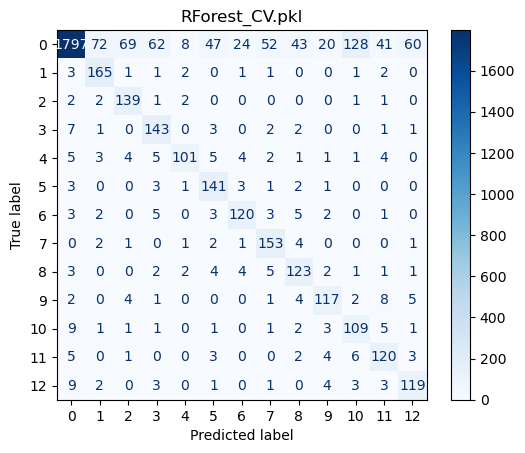

              precision    recall  f1-score   support

           0       0.97      0.74      0.84      2423
           1       0.66      0.93      0.77       177
           2       0.63      0.94      0.76       148
           3       0.63      0.89      0.74       160
           4       0.86      0.74      0.80       136
           5       0.67      0.91      0.77       155
           6       0.76      0.83      0.80       144
           7       0.69      0.93      0.79       165
           8       0.65      0.83      0.73       148
           9       0.76      0.81      0.79       144
          10       0.43      0.81      0.56       134
          11       0.64      0.83      0.73       144
          12       0.62      0.82      0.71       145

    accuracy                           0.79      4223
   macro avg       0.69      0.85      0.75      4223
weighted avg       0.84      0.79      0.80      4223



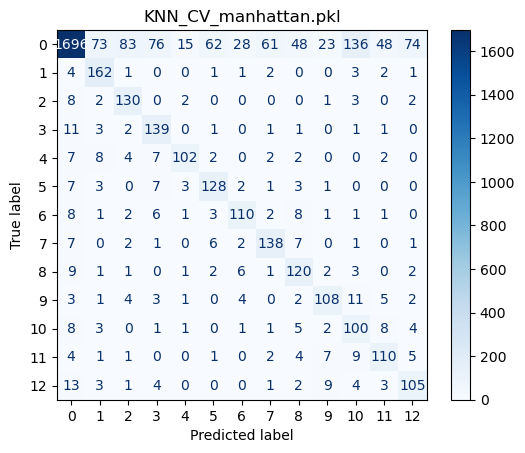

              precision    recall  f1-score   support

           0       0.95      0.70      0.81      2423
           1       0.62      0.92      0.74       177
           2       0.56      0.88      0.69       148
           3       0.57      0.87      0.69       160
           4       0.81      0.75      0.78       136
           5       0.62      0.83      0.71       155
           6       0.71      0.76      0.74       144
           7       0.65      0.84      0.73       165
           8       0.59      0.81      0.69       148
           9       0.70      0.75      0.72       144
          10       0.37      0.75      0.49       134
          11       0.61      0.76      0.68       144
          12       0.54      0.72      0.62       145

    accuracy                           0.75      4223
   macro avg       0.64      0.79      0.70      4223
weighted avg       0.81      0.75      0.76      4223



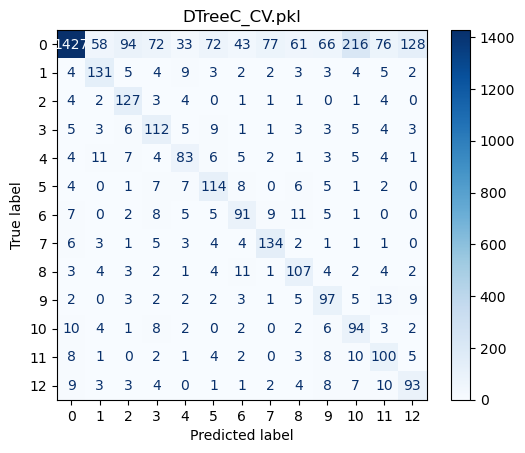

              precision    recall  f1-score   support

           0       0.96      0.59      0.73      2423
           1       0.60      0.74      0.66       177
           2       0.50      0.86      0.63       148
           3       0.48      0.70      0.57       160
           4       0.54      0.61      0.57       136
           5       0.51      0.74      0.60       155
           6       0.52      0.63      0.57       144
           7       0.58      0.81      0.68       165
           8       0.51      0.72      0.60       148
           9       0.46      0.67      0.55       144
          10       0.27      0.70      0.39       134
          11       0.44      0.69      0.54       144
          12       0.38      0.64      0.48       145

    accuracy                           0.64      4223
   macro avg       0.52      0.70      0.58      4223
weighted avg       0.76      0.64      0.66      4223



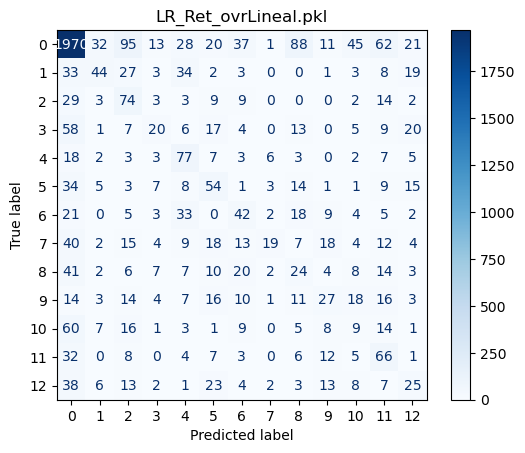

              precision    recall  f1-score   support

           0       0.82      0.81      0.82      2423
           1       0.41      0.25      0.31       177
           2       0.26      0.50      0.34       148
           3       0.29      0.12      0.17       160
           4       0.35      0.57      0.43       136
           5       0.29      0.35      0.32       155
           6       0.27      0.29      0.28       144
           7       0.53      0.12      0.19       165
           8       0.12      0.16      0.14       148
           9       0.26      0.19      0.22       144
          10       0.08      0.07      0.07       134
          11       0.27      0.46      0.34       144
          12       0.21      0.17      0.19       145

    accuracy                           0.58      4223
   macro avg       0.32      0.31      0.29      4223
weighted avg       0.59      0.58      0.58      4223



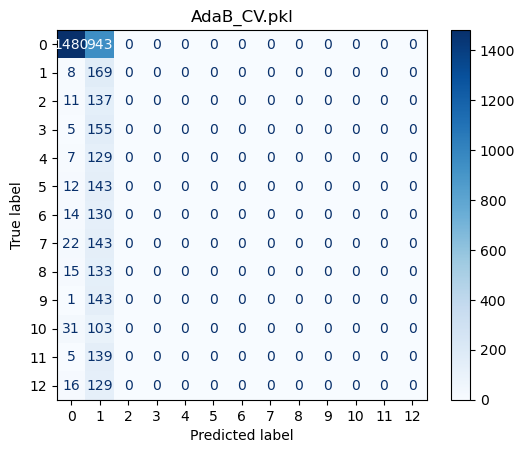

              precision    recall  f1-score   support

           0       0.91      0.61      0.73      2423
           1       0.07      0.95      0.12       177
           2       0.00      0.00      0.00       148
           3       0.00      0.00      0.00       160
           4       0.00      0.00      0.00       136
           5       0.00      0.00      0.00       155
           6       0.00      0.00      0.00       144
           7       0.00      0.00      0.00       165
           8       0.00      0.00      0.00       148
           9       0.00      0.00      0.00       144
          10       0.00      0.00      0.00       134
          11       0.00      0.00      0.00       144
          12       0.00      0.00      0.00       145

    accuracy                           0.39      4223
   macro avg       0.07      0.12      0.07      4223
weighted avg       0.52      0.39      0.42      4223



In [25]:
#for i, row in dr.sort_values(by='f1_score', ascending=False).iterrows():
for i, row in dr.sort_values(by='accuracy', ascending=False).iterrows():
    model_name = row['model']
    
    if archivo_modelo.endswith('.pkl'):
        ruta_completa = os.path.join(ruta_modelos, model_name)
    
        # Carga el modelo
        modelo_cargado = joblib.load(ruta_completa)

        # Realizar predicciones (opcional)
        y_pred = modelo_cargado.predict(Xp)

        # Calcular la matriz de confusión
        cm = confusion_matrix(yp, y_pred)
        
        # Crear la visualización de la matriz de confusión
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(yp))
        
        # Mostrar la visualización
        disp.plot(cmap='Blues')
        
        # Configurar el título
        plt.title(model_name)
        
        # Mostrar la figura
        plt.show()

        # Mostrar el informe de clasificación
        print(classification_report(yp, y_pred))


#### ROC - Receiver Operating Characteristic

0.9854278265: RForest_CV.pkl


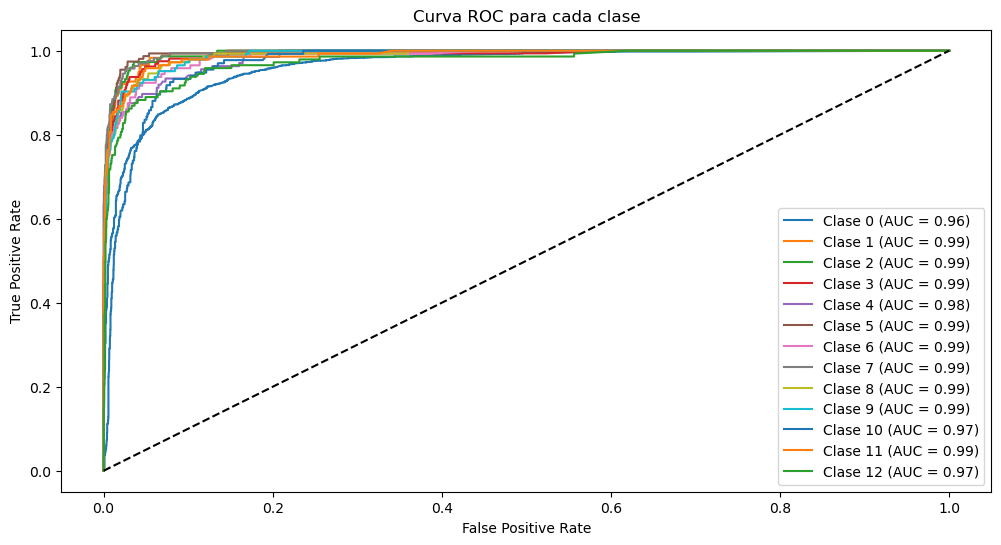

0.9392348833: KNN_CV_manhattan.pkl


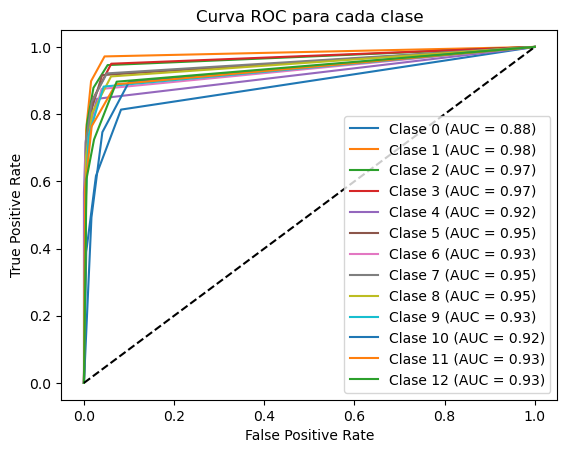

0.8353511430: DTreeC_CV.pkl


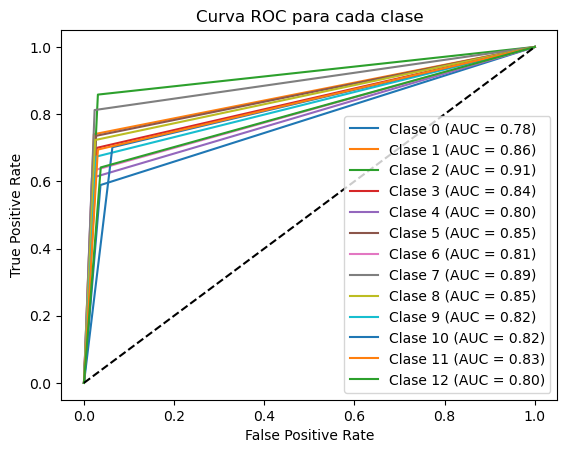

0.7889318217: LR_Ret_ovrLineal.pkl


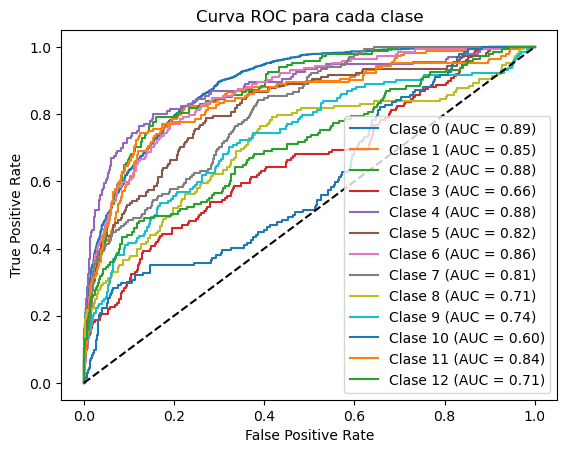

0.6528367974: AdaB_CV.pkl


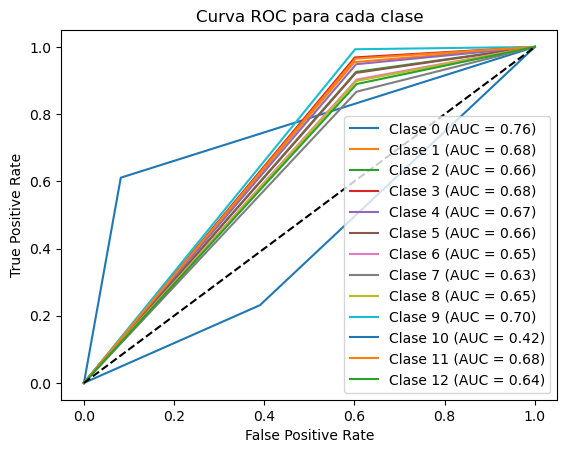

In [26]:
# Crear figura de tamaño 10x6
fig = plt.figure(figsize=(12, 6))  


for i, row in dr.sort_values(by='accuracy', ascending=False).iterrows():
    model_name = row['model']
    
    if archivo_modelo.endswith('.pkl'):
        ruta_completa = os.path.join(ruta_modelos, model_name)
    
        # Carga el modelo
        modelo_cargado = joblib.load(ruta_completa)
        
        
        # Obtener probabilidades de predicción del modelo
        probs = modelo_cargado.predict_proba(Xp)        

        classes = np.unique(yp)
        yp_binarized = label_binarize(yp, classes=classes)

        # Calcular el AUC-ROC
        auc = roc_auc_score(yp_binarized, probs,multi_class='ovr') 
        
        # Mostrar el AUC-ROC y el nombre del modelo
        print("{:.10f}: {}".format(auc, model_name))

        # Graficar la curva ROC para cada clase
        for i, class_label in enumerate(classes):
            fpr, tpr, _ = roc_curve(yp_binarized[:, i], probs[:, i])
            plt.plot(fpr, tpr, label=f'Clase {class_label} (AUC = {roc_auc_score(yp_binarized[:, i], probs[:, i]):.2f})')
            
        # Graficar la línea de referencia diagonal
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Curva ROC para cada clase')
        plt.legend(loc="lower right")
        plt.show() 

## Conclusiones

* Como era de esperarse, la selección de los parámetros para los modelos es fundamental en los resultados de los mismos, para nuestro caso scoring f1 no arrojó resultados en 2 de ellos.
* La selección del número de pliegues(CV) también es fundamental ya que un número alto requiere mucho tiempo de computo y no necesariamente arroja mejores resultados en los modelos.
* Random Forest tardó cerca de 2 horas en correr los modelos con los parámetros que se seleccionaron.
* Los modelos basados en árboles son más susceptibles a los parámetros, valores bajos llevan a sub-entrenamiento "underfitting", con pocas opciones en la clasificación,  y valores altos llevan a sobre-entrenamiento  y "overfitting", aprendiendo las respuestas, perdiendo, en ambos casos, la capacidad de generalizar.
* A sabiendas de que la regresión logística es más adecuado para clasificaciones binarias quisimos probarlo en nuestro sistema multiclase arrojando como resultado una pobre clasificación.
* Ada-boost tampoco nos entregó buenos resultados ya que el clasificador simple en que se apoyó, árbol de decisión, mostró overfitting con los parámetro seleccionados. No insistimos en este modelo por los tiempos de ejecución altos.


#### Referencias


- *scikit-learn:*   
    - https://scikit-learn.org/stable/modules/svm.html
    
    ROC
    - https://stackabuse.com/understanding-roc-curves-with-python/



- *Gráficas con  seaborn:*
    - https://ichi.pro/es/como-utilizar-python-seaborn-para-analisis-de-datos-exploratorios-28897898172180



- *Analítica de grandes datos:*
    - https://jdvelasq.github.io/courses/analitica-de-grandes-datos/index.html